#**GroupBy Recommender**

Based on neural collaborative filtering and modeled with Keras. Use the total number of orders of a particular product to measure the popularity of the product.

References:

1. https://arxiv.org/pdf/1708.05031.pdf

2. https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recommender/neural_collaborative_filtering

3. https://keras.io/examples/structured_data/collaborative_filtering_movielens/

4. https://www.cv-foundation.org/openaccess/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html (initializer used)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/GroupBy_final'

/content/drive/MyDrive/Colab Notebooks/GroupBy_final


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

##Data preparation
Use the total number of orders as an indication of the popularity of the product.

In [4]:
# Load data
df = pd.read_csv('df_json_final_ver_2.csv')

In [ ]:
print(df.shape)
df.head()

(1578809, 35)


,product_id,product_name,product_price,product_brand,event_time,last_session_event,total_price_cart,customerId,customerVisitorId,customerLoginId,customerSessionId,sessionStartTime,sessionEndTime,customerSessionNumber,timeOnSite,totals_events,newSession,totalViewProducts,totalViewProductRevenue,uniqueViewProducts,totalAddToCarts,totalAddToCartRevenue,uniqueAddToCarts,totalOrders,totalOrderRevenue,uniqueOrders,event_type_cart,event_type_purchase,hits.eventType.category_search,event_type_view,month,hour,Wednesday,weekend,holiday
0,BR013,nutritional yeast seasoning,4.99,Bragg,2020-12-02 03:03:04.214607,True,0.0,swansonhealth,cki6s4tr200013bdpkaye9mdn,anonymous,cki6s4tr200013bdpkaye9mdn1606878184,2020-12-02 03:03:04.214607 UTC,2020-12-02 03:03:04.214607 UTC,1,00:00:00,1,True,1,4.99,1,0,0.0,0,0,0.0,0,0,0,0,1,12,3,1,0,False
1,DRB004,pure castile bar soap peppermint,4.50,Dr. Bronner's,2020-12-02 02:06:37.430706,True,0.0,swansonhealth,cki6rrijb000125c5cdol7ahd,anonymous,cki6rrijb000125c5cdol7ahd1606874797,2020-12-02 02:06:37.430706 UTC,2020-12-02 02:06:37.430706 UTC,1,00:00:00,1,True,1,4.50,1,0,0.0,0,0,0.0,0,0,0,0,1,12,2,1,0,False
2,SUS022,100% daily value multi-vitamin,8.39,Superior Source,2020-12-02 03:16:23.189961,True,0.0,swansonhealth,cki6uboil00013he8jwwj434w,anonymous,cki6uboil00013he8jwwj434w1606878983,2020-12-02 03:16:23.189961 UTC,2020-12-02 03:16:23.189961 UTC,1,00:00:00,1,True,1,8.39,1,0,0.0,0,0,0.0,0,0,0,0,1,12,3,1,0,False
3,NLS002,natural elderberry concentrate blend,11.99,Natural Sources,2020-12-02 03:47:05.891081,True,0.0,swansonhealth,cki6vcrm500013vcysh1hk38z,anonymous,cki6vcrm500013vcysh1hk38z1606880825,2020-12-02 03:47:05.891081 UTC,2020-12-02 03:47:05.891081 UTC,1,00:00:00,1,True,1,11.99,1,0,0.0,0,0,0.0,0,0,0,0,1,12,3,1,0,False
4,MOM002,organic hair remover with tea tree refill jar,10.49,Moom,2020-12-02 03:49:57.342691,True,0.0,swansonhealth,cki6vggk900013xe68nl4dao3,anonymous,cki6vggk900013xe68nl4dao31606880997,2020-12-02 03:49:57.342691 UTC,2020-12-02 03:49:57.342691 UTC,1,00:00:00,1,True,1,10.49,1,0,0.0,0,0,0.0,0,0,0,0,1,12,3,1,0,False


In [5]:
df.isnull().sum()

product_id                          0
product_name                      216
product_price                       0
product_brand                       0
event_time                          0
last_session_event                  0
total_price_cart                    0
customerId                          0
customerVisitorId                   0
customerLoginId                     0
customerSessionId                   0
sessionStartTime                    0
sessionEndTime                      0
customerSessionNumber               0
timeOnSite                          0
totals_events                       0
newSession                          0
totalViewProducts                   0
totalViewProductRevenue             0
uniqueViewProducts                  0
totalAddToCarts                     0
totalAddToCartRevenue               0
uniqueAddToCarts                    0
totalOrders                         0
totalOrderRevenue                   0
uniqueOrders                        0
event_type_c

In [6]:
df['product_name'].fillna('unknown', inplace=True)

In [7]:
df[['product_id', 'product_name']].nunique()

product_id      13773
product_name    13309
dtype: int64

In [8]:
# Create dataframe with the required information for the model
data = df[['customerVisitorId', 'product_id', 'totalOrders']]
data.head()

,customerVisitorId,product_id,totalOrders
0,cki6s4tr200013bdpkaye9mdn,BR013,0
1,cki6rrijb000125c5cdol7ahd,DRB004,0
2,cki6uboil00013he8jwwj434w,SUS022,0
3,cki6vcrm500013vcysh1hk38z,NLS002,0
4,cki6vggk900013xe68nl4dao3,MOM002,0


In [9]:
# Encode customer and product IDs as integer indices
customer_ids = data['customerVisitorId'].unique().tolist()
customer2customer_encoded = {x: i for i, x in enumerate(customer_ids)}
customer_encoded2customer = {i: x for i, x in enumerate(customer_ids)}
product_ids = data['product_id'].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}

In [10]:
# Create new dataframe with new columns containing the encoded data
data_new = data.copy()
data_new['customer'] = data['customerVisitorId'].map(customer2customer_encoded)
data_new['product'] = data['product_id'].map(product2product_encoded)

# Convert totalOrders to float type
data_new['totalOrders'] = data['totalOrders'].values.astype(np.float32)

data_new.head()

,customerVisitorId,product_id,totalOrders,customer,product
0,cki6s4tr200013bdpkaye9mdn,BR013,0.0,0,0
1,cki6rrijb000125c5cdol7ahd,DRB004,0.0,1,1
2,cki6uboil00013he8jwwj434w,SUS022,0.0,2,2
3,cki6vcrm500013vcysh1hk38z,NLS002,0.0,3,3
4,cki6vggk900013xe68nl4dao3,MOM002,0.0,4,4


In [11]:
# Number of customers and products
num_customers = len(customer2customer_encoded)
num_products = len(product_encoded2product)
print(f'Number of customers: {num_customers}, Number of products: {num_products}')

Number of customers: 44576, Number of products: 13773


In [12]:
# Prepare training, validation and testing data

from sklearn.model_selection import train_test_split

data_new = data_new.sample(frac=1, random_state=42)
X = data_new[['customer', 'product']].values

# Normalize the targets between 0 and 1
min_orders = min(data_new['totalOrders'])
max_orders = max(data_new['totalOrders'])
y = data_new['totalOrders'].apply(lambda x: (x - min_orders) / (max_orders - min_orders)).values

# Data split = 80% training, 10% validation, 10% testing
#train_indices = int(0.8 * data_new.shape[0])
#x_train, x_val, y_train, y_val = (x[:train_indices],x[train_indices:], y[:train_indices], y[train_indices:])
X_train, X_inter, y_train, y_inter = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_inter, y_inter, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1263047, 2) (157881, 2) (157881, 2)
(1263047,) (157881,) (157881,)


##Model

(as presented in Ref. 3)

In [13]:
# Embed customer and product data into 50-dimensional vectors
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_customers, num_products, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_customers = num_customers
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.customer_embedding = layers.Embedding(
            num_customers,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.customer_bias = layers.Embedding(num_customers, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        customer_vector = self.customer_embedding(inputs[:, 0])
        customer_bias = self.customer_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])
        dot_customer_product = tf.tensordot(customer_vector, product_vector, 2)
        # Add all the components (including bias)
        x = dot_customer_product + customer_bias + product_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [14]:
model = RecommenderNet(num_customers, num_products, EMBEDDING_SIZE)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [15]:
# Train the model based on the data split
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
19736/19736 [==============================] - 151s 8ms/step - loss: 0.1824 - accuracy: 0.6692 - val_loss: 0.1524 - val_accuracy: 0.6722
Epoch 2/100
19736/19736 [==============================] - 149s 8ms/step - loss: 0.1534 - accuracy: 0.6724 - val_loss: 0.1563 - val_accuracy: 0.6720
Epoch 3/100
19736/19736 [==============================] - 148s 7ms/step - loss: 0.1591 - accuracy: 0.6722 - val_loss: 0.1625 - val_accuracy: 0.6718
Epoch 4/100
19736/19736 [==============================] - 149s 8ms/step - loss: 0.1654 - accuracy: 0.6722 - val_loss: 0.1680 - val_accuracy: 0.6717
Epoch 5/100
19736/19736 [==============================] - 149s 8ms/step - loss: 0.1709 - accuracy: 0.6720 - val_loss: 0.1730 - val_accuracy: 0.6716
Epoch 6/100
19736/19736 [==============================] - 148s 8ms/step - loss: 0.1758 - accuracy: 0.6719 - val_loss: 0.1752 - val_accuracy: 0.6716
Epoch 7/100
19736/19736 [==============================] - 151s 8ms/step - loss: 0.1796 - accuracy: 0.6718

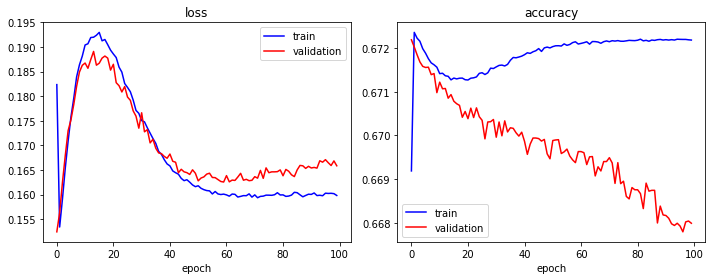

In [22]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(range(len(history.history['loss'])), history.history['loss'], color='blue', label='train')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='red', label='validation')
plt.title('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], color='blue', label='train')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='red', label='validation')
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2228800   
_________________________________________________________________
embedding_1 (Embedding)      multiple                  44576     
_________________________________________________________________
embedding_2 (Embedding)      multiple                  688650    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  13773     
Total params: 2,975,799
Trainable params: 2,975,799
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Evaluate the model on the test data set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test data: {accuracy*100:.2f}%')    

Accuracy on test data: 66.99%


##Recommendations

In [ ]:
# Extract required data from dataframe
data_rec = df[['customerVisitorId', 'product_id', 'product_name']]

# Select a customer for the recommendations 
customer_id = data_rec.customerVisitorId.sample(1).iloc[0]
print(customer_id)

ckfr77ndr00013bcdu11ey9tu


In [ ]:
print(data_rec['product_id'].nunique())
data_rec.head()

13773


,customerVisitorId,product_id,product_name
0,cki6s4tr200013bdpkaye9mdn,BR013,nutritional yeast seasoning
1,cki6rrijb000125c5cdol7ahd,DRB004,pure castile bar soap peppermint
2,cki6uboil00013he8jwwj434w,SUS022,100% daily value multi-vitamin
3,cki6vcrm500013vcysh1hk38z,NLS002,natural elderberry concentrate blend
4,cki6vggk900013xe68nl4dao3,MOM002,organic hair remover with tea tree refill jar


In [ ]:
# Identify unique products purchased by the customer
products_purchased_by_customer = data_rec[data_rec.customerVisitorId == customer_id]
print(products_purchased_by_customer.shape)
products_purchased_by_customer['product_id'].nunique()

(520, 3)


230

In [ ]:
products_purchased_by_customer.head()

,customerVisitorId,product_id,product_name
385660,ckfr77ndr00013bcdu11ey9tu,SNW023,warrior blend protein - vanilla
385661,ckfr77ndr00013bcdu11ey9tu,NTA014,pea protein vegan shake - vanilla
385662,ckfr77ndr00013bcdu11ey9tu,PFU001,complete protein - creamy vanilla bean
385663,ckfr77ndr00013bcdu11ey9tu,PVG001,plant protein+ - vanilla
385664,ckfr77ndr00013bcdu11ey9tu,GLF145,22 oz pwdr


In [ ]:
# Search products not purchased by the customer to recommend
products_not_purchased = data_rec[~data_rec['product_id'].isin(products_purchased_by_customer.product_id.values)]['product_id']
print(products_not_purchased.shape)
print(products_not_purchased.nunique())

(1514916,)
13543


In [ ]:
products_not_purchased = list(set(products_not_purchased).intersection(set(product2product_encoded.keys())))
products_not_purchased = [[product2product_encoded.get(x)] for x in products_not_purchased]
customer_encoder = customer2customer_encoded.get(customer_id)
customer_product_array = np.hstack(([[customer_encoder]] * len(products_not_purchased), products_not_purchased))

In [ ]:
# Predict products to recommend
orders_predict = model.predict(customer_product_array).flatten()

In [ ]:
# Select top 10 recommendations
top_orders_indices = orders_predict.argsort()[-10:][::-1]
recommended_product_ids = [product_encoded2product.get(products_not_purchased[x][0]) for x in top_orders_indices]
recommended_products = data_rec[data_rec['product_id'].isin(recommended_product_ids)].drop_duplicates(subset='product_id')

In [ ]:
# Print recommendations

print(f'Top 10 product recommendations for customer: {customer_id}')
print('----' * 8)

for row in recommended_products.itertuples():
    print(row.product_id, ":", row.product_name)

Top 10 product recommendations for customer: ckfr77ndr00013bcdu11ey9tu
--------------------------------
AMT007 : catuaba
DCR080 : liver & gallbladder formula
JOC001 : colombian - whole bean
IE009 : male vitality
NWF955 : better stevia liquid sweetener - hazelnut
MSN063 : shark fin cartilage
DRB047 : 4-in-1 organic sugar soap - peppermint
NAT140 : white willow
SW129813 : prebiotic jerusalem artichoke - 90% inulin
SLR2296 : blood pressure factors


Check new customer

In [ ]:
customer = 'I_am_a_new_customer'


In [ ]:
# Identify unique products purchased by the customer
if not customer in data_rec['customerVisitorId']:
  products_purchased_by_customer = pd.DataFrame(data=[[customer, 'no_product', 'no_product']], 
                                                columns=['customerVisitorId', 'product_id', 'product_name'])
else:
  products_purchased_by_customer = data_rec[data_rec.customerVisitorId == customer]

print(products_purchased_by_customer.shape)
products_purchased_by_customer['product_id'].nunique()

(1, 3)


1

In [ ]:
# Search products not purchased by the customer to recommend
products_not_purchased = data_rec[~data_rec['product_id'].isin(products_purchased_by_customer.product_id.values)]['product_id']
print(products_not_purchased.shape)
print(products_not_purchased.nunique())

(1578809,)
13773


In [ ]:
products_not_purchased = list(set(products_not_purchased).intersection(set(product2product_encoded.keys())))
products_not_purchased = [[product2product_encoded.get(x)] for x in products_not_purchased]
customer_encoder = data_rec.shape[0] + 1
customer_product_array = np.hstack(([[customer_encoder]] * len(products_not_purchased), products_not_purchased))

In [ ]:
# Predict products to recommend
orders_predict = model.predict(customer_product_array).flatten()

In [ ]:
# Select top 10 recommendations
top_orders_indices = orders_predict.argsort()[-10:][::-1]
recommended_product_ids = [product_encoded2product.get(products_not_purchased[x][0]) for x in top_orders_indices]
recommended_products = data_rec[data_rec['product_id'].isin(recommended_product_ids)].drop_duplicates(subset='product_id')

In [ ]:
# Print recommendations

print(f'Top 10 product recommendations for customer: {customer}')
print('----' * 8)

for row in recommended_products.itertuples():
    print(row.product_id, ":", row.product_name)

Top 10 product recommendations for customer: I_am_a_new_customer
--------------------------------
SW1082 : acai berry
HMG035 : sprouting seeds spicy salad mix
NAT164 : 900 mg 90 veg caps
QU058 : 0.33 fl oz gel
SWH266 : pomegranate complex
IE009 : male vitality
DRB047 : 4-in-1 organic sugar soap - peppermint
NAT140 : white willow
EC041 : venus fly trap
SLR2296 : blood pressure factors


##Hyperparameter tuning

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 97 kB 4.7 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
hp = kt.HyperParameters()
# Recompile and train the model
def rebuild_model(hp):
  model_tune = RecommenderNet(num_customers, num_products, EMBEDDING_SIZE)
  # Select learning rate
  hp_lrate = hp.Choice(name='learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001])
  model_tune.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=hp_lrate), metrics=['accuracy'])
  return model_tune

In [ ]:
# Initialize the tuner
tuner = kt.RandomSearch(rebuild_model, objective='val_loss', max_trials=5, overwrite=True)

In [ ]:
# Search for best model
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1) 
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 24m 22s]
val_loss: 10.17583179473877

Best val_loss So Far: 0.12768612802028656
Total elapsed time: 02h 01m 19s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]

print(best_hps.get('learning_rate'))

0.001


In [ ]:
# Build and train the model with the optimal hyperparameters
model_tuned = tuner.hypermodel.build(best_hps)
history_tuned = model_tuned.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1)
val_acc_per_epoch = history_tuned.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch:d}')

Epoch 1/100
39471/39471 [==============================] - 140s 4ms/step - loss: 0.1765 - accuracy: 0.6698 - val_loss: 0.1457 - val_accuracy: 0.6722
Epoch 2/100
39471/39471 [==============================] - 139s 4ms/step - loss: 0.1421 - accuracy: 0.6724 - val_loss: 0.1408 - val_accuracy: 0.6721
Epoch 3/100
39471/39471 [==============================] - 139s 4ms/step - loss: 0.1383 - accuracy: 0.6724 - val_loss: 0.1381 - val_accuracy: 0.6722
Epoch 4/100
39471/39471 [==============================] - 139s 4ms/step - loss: 0.1358 - accuracy: 0.6724 - val_loss: 0.1350 - val_accuracy: 0.6722
Epoch 5/100
39471/39471 [==============================] - 139s 4ms/step - loss: 0.1334 - accuracy: 0.6724 - val_loss: 0.1329 - val_accuracy: 0.6722
Epoch 6/100
39471/39471 [==============================] - 139s 4ms/step - loss: 0.1313 - accuracy: 0.6724 - val_loss: 0.1312 - val_accuracy: 0.6722
Epoch 7/100
39471/39471 [==============================] - 139s 4ms/step - loss: 0.1296 - accuracy: 0.6724

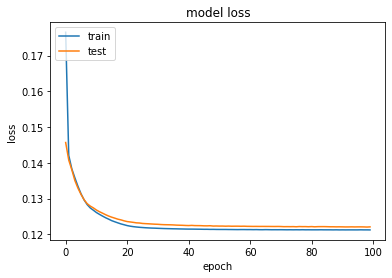

In [ ]:
# Plot training and validation loss

plt.plot(history_tuned.history["loss"])
plt.plot(history_tuned.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_epoch, verbose=1)

Epoch 1/17
39471/39471 [==============================] - 137s 3ms/step - loss: 0.1767 - accuracy: 0.6698 - val_loss: 0.1458 - val_accuracy: 0.6722
Epoch 2/17
39471/39471 [==============================] - 136s 3ms/step - loss: 0.1423 - accuracy: 0.6724 - val_loss: 0.1408 - val_accuracy: 0.6721
Epoch 3/17
39471/39471 [==============================] - 136s 3ms/step - loss: 0.1385 - accuracy: 0.6724 - val_loss: 0.1376 - val_accuracy: 0.6722
Epoch 4/17
39471/39471 [==============================] - 136s 3ms/step - loss: 0.1355 - accuracy: 0.6724 - val_loss: 0.1348 - val_accuracy: 0.6721
Epoch 5/17
39471/39471 [==============================] - 136s 3ms/step - loss: 0.1330 - accuracy: 0.6724 - val_loss: 0.1327 - val_accuracy: 0.6722
Epoch 6/17
39471/39471 [==============================] - 136s 3ms/step - loss: 0.1311 - accuracy: 0.6724 - val_loss: 0.1311 - val_accuracy: 0.6721
Epoch 7/17
39471/39471 [==============================] - 136s 3ms/step - loss: 0.1295 - accuracy: 0.6724 - val_

In [ ]:
# Save model - default Keras method
hypermodel.save('/content/drive/MyDrive/Colab Notebooks/GroupBy_v2/recommender')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/GroupBy_v2/recommender/assets


In [ ]:
# Evaluate the model on the test data set
loss, accuracy = hypermodel.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test data: {accuracy*100:.2f}%')    

Accuracy on test data: 67.22%
